# $$ CLASSIFICATION $$

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix

### Loading Data and print info

In [2]:
frame = pd.read_csv("adult_train.csv")
print("Frame shape: "+str(frame.shape))
frame.info()

Frame shape: (32530, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32530 entries, 0 to 32529
Data columns (total 15 columns):
Age               32530 non-null int64
Workclass         30695 non-null object
fnlwgt            31306 non-null float64
Education         32530 non-null object
Education_Num     32530 non-null int64
Martial_Status    32530 non-null object
Occupation        30688 non-null object
Relationship      32530 non-null object
Race              32530 non-null object
Sex               32530 non-null object
Capital_Gain      32530 non-null int64
Capital_Loss      32530 non-null int64
Hours_per_week    32530 non-null int64
Country           31948 non-null object
Target            32530 non-null object
dtypes: float64(1), int64(5), object(9)
memory usage: 3.7+ MB


In [3]:
frame.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,NaN,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Duplicates doesn't exist in the dataset

In [4]:
frame.duplicated().sum()
frame.drop_duplicates(inplace=True)
frame.shape

(32530, 15)

### Display nulls per column

In [5]:
frame.isnull().sum()/len(frame)

Age               0.000000
Workclass         0.056409
fnlwgt            0.037627
Education         0.000000
Education_Num     0.000000
Martial_Status    0.000000
Occupation        0.056625
Relationship      0.000000
Race              0.000000
Sex               0.000000
Capital_Gain      0.000000
Capital_Loss      0.000000
Hours_per_week    0.000000
Country           0.017891
Target            0.000000
dtype: float64

## Data Exploration

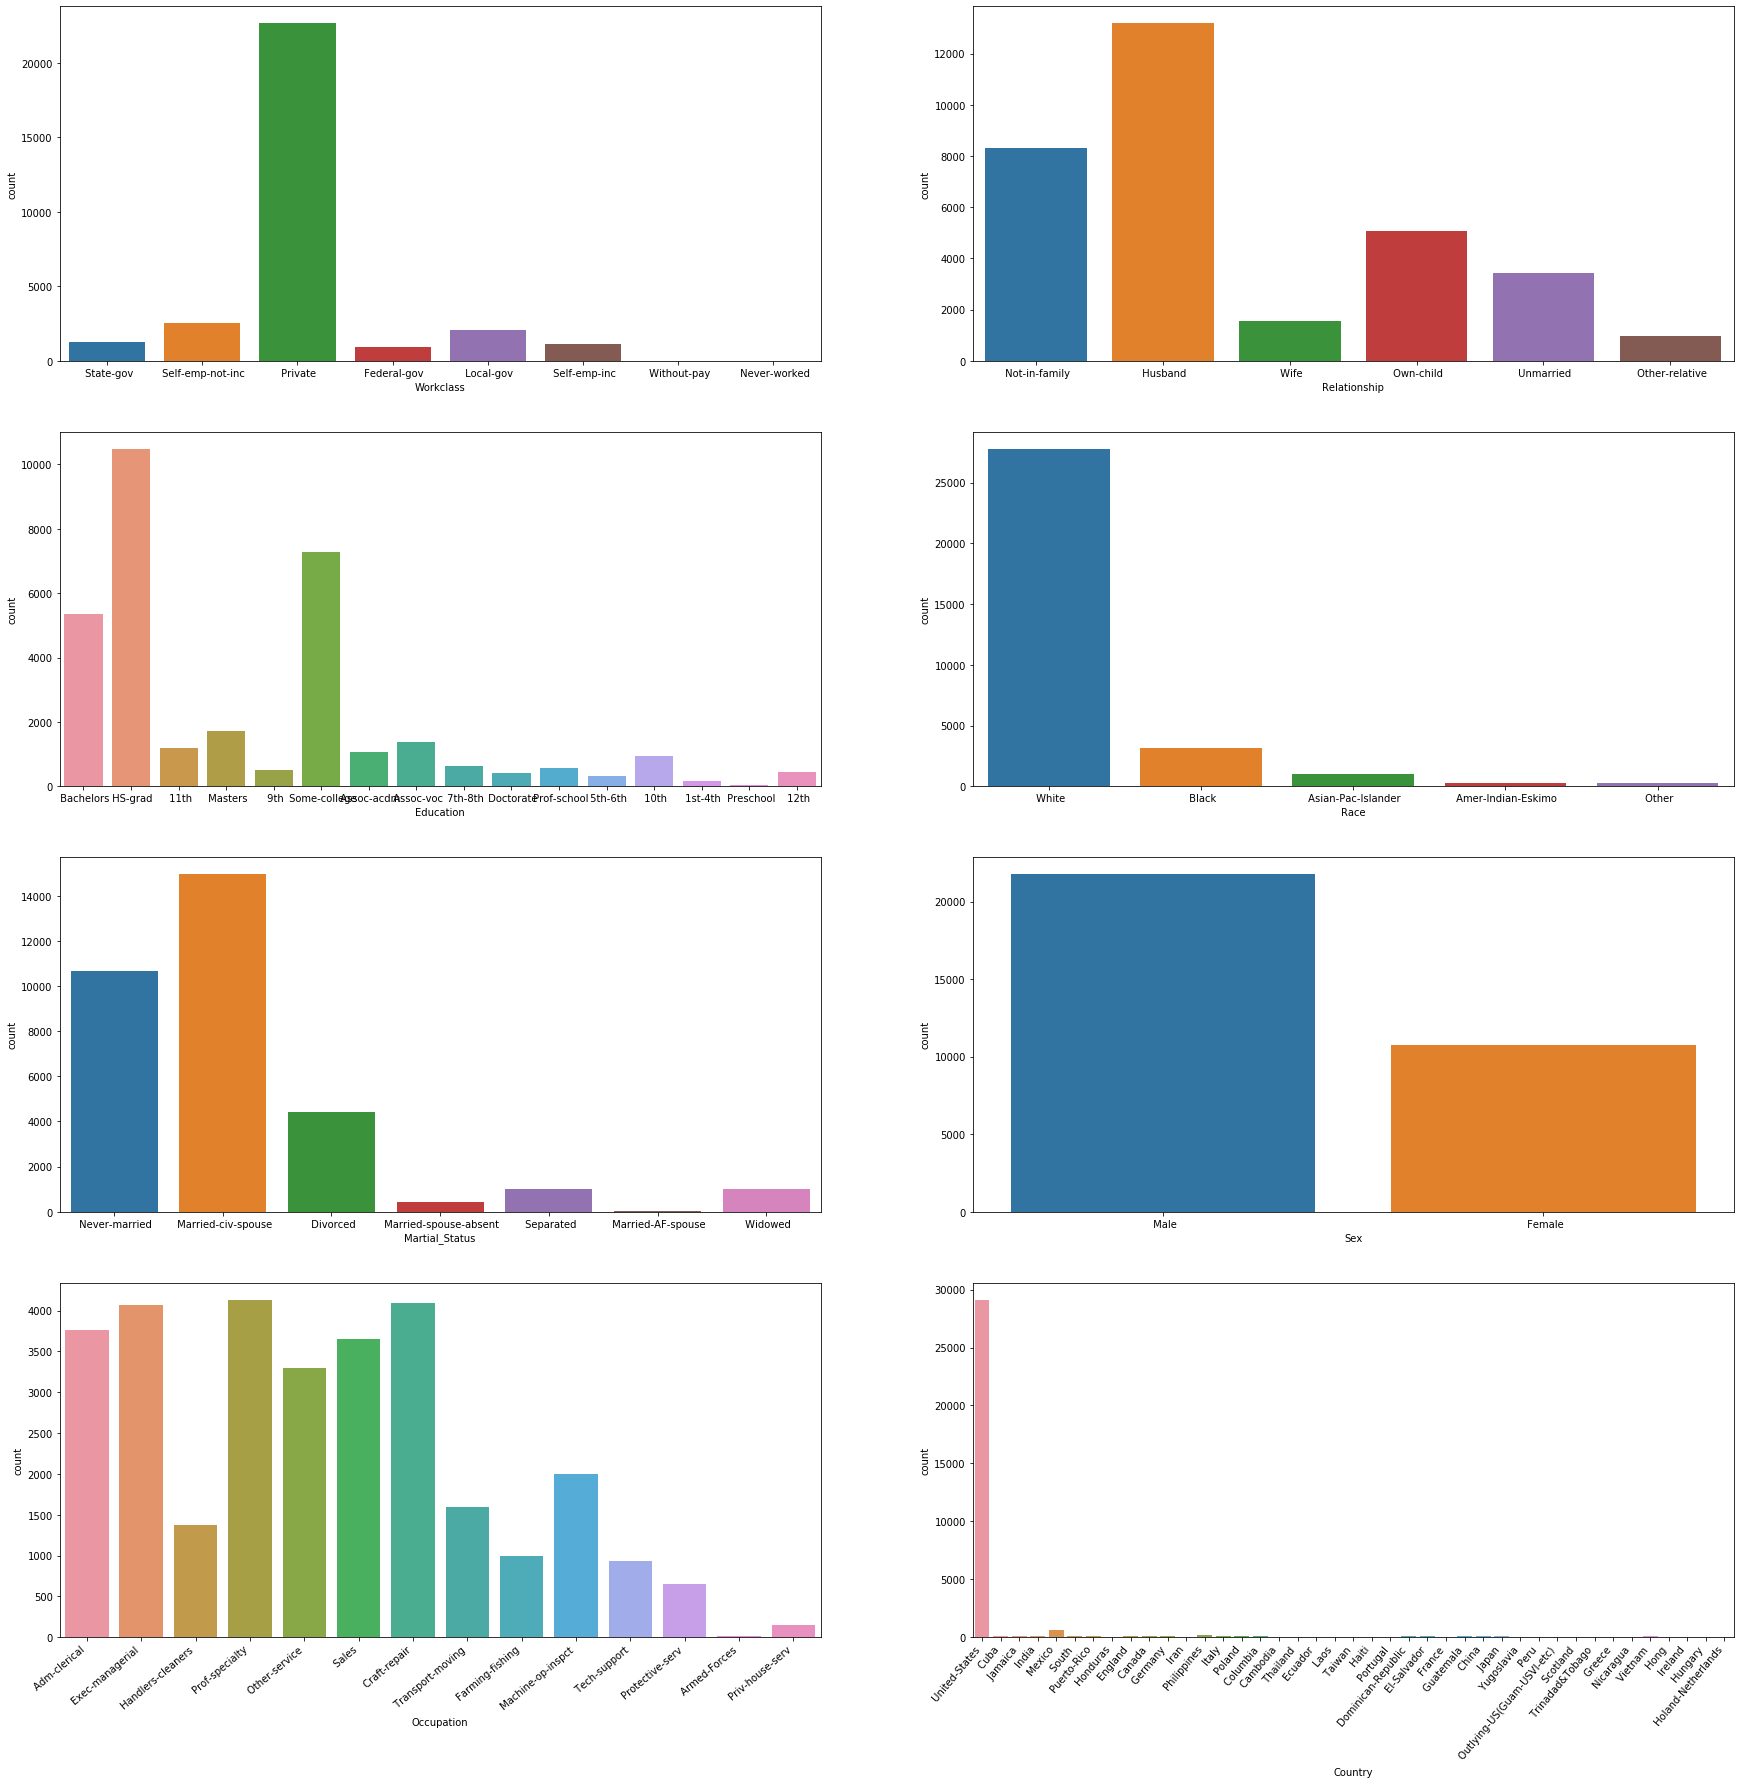

In [6]:
f, axes = plt.subplots(4, 2)
fig = plt.gcf()
fig.set_size_inches(30,30)

sns.countplot(x='Workclass', data=frame, ax=axes[0,0])
sns.countplot(x='Education', data=frame, ax=axes[1,0])
sns.countplot(x='Martial_Status', data=frame, ax=axes[2,0])
occupation = sns.countplot(x='Occupation', data=frame, ax=axes[3,0])
occupation.set_xticklabels(occupation.get_xticklabels(), rotation=40, ha="right")


sns.countplot(x='Relationship', data=frame, ax=axes[0,1])
sns.countplot(x='Race', data=frame, ax=axes[1,1])
sns.countplot(x='Sex', data=frame, ax=axes[2,1])
country = sns.countplot(x='Country', data=frame, ax=axes[3,1])
country.set_xticklabels(country.get_xticklabels(), rotation=50, ha="right")
plt.show()

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num',
       'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target'],
      dtype='object')

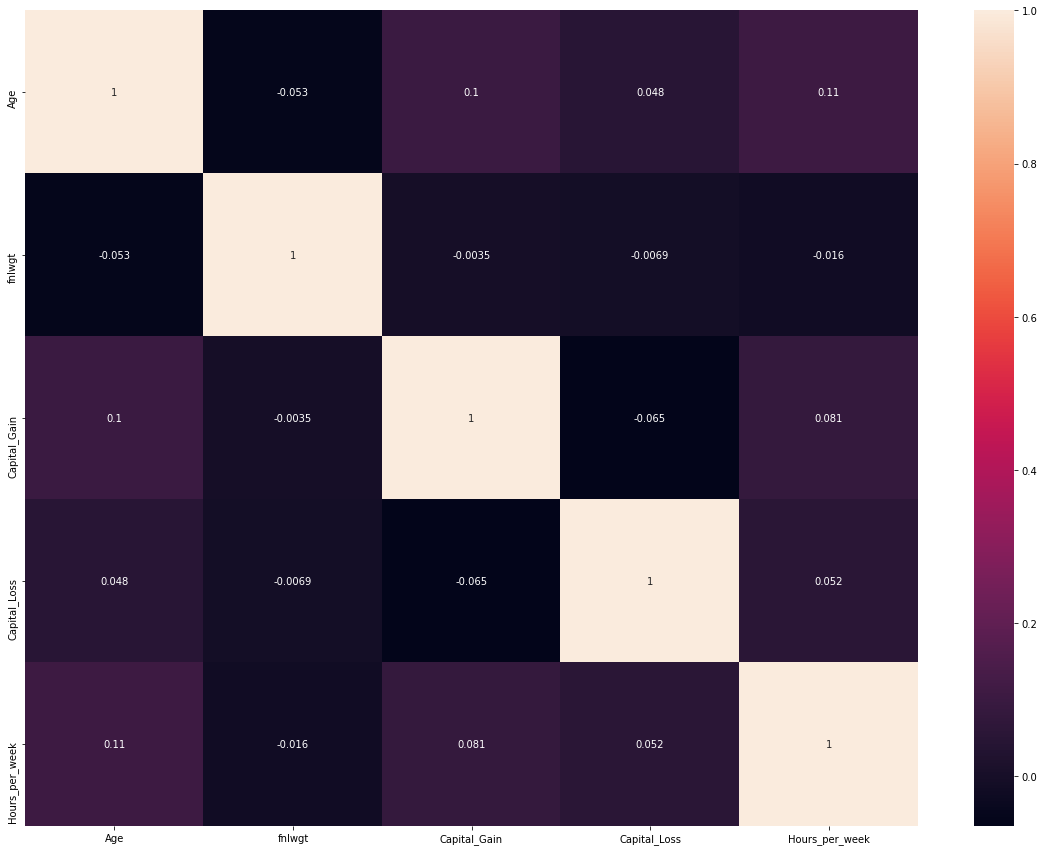

In [7]:
corr = frame[["Age","fnlwgt","Capital_Gain","Capital_Loss","Hours_per_week"]].corr(method='kendall')
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True)
frame.columns

# Handling Missing data

Columns with missing data are Workclass, fnlwgt, occupation, country. Rows which doesn't have occupation also have workclass missing. It is hard to fill the missing values. So dropping all the rows which doesn't have occupation. 

In [8]:
frame = frame[~frame['Occupation'].isnull()]
frame.isnull().sum()

Age                  0
Workclass            0
fnlwgt            1152
Education            0
Education_Num        0
Martial_Status       0
Occupation           0
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            555
Target               0
dtype: int64

## Logic implemented behind the update Functions


### Update final weight column
Usually occupation and the yearly wage are directly related to each other. Using this logic we are imputing the fnlwgt column. 

 - Step 1: We created a data frame with occupation, mean(fnlwgt)
 - Step 2: We imputed the missing fnlwgt column. by joining the data frame (with missing values) with the data frame generated in Step 1.
 - Step 3: Built the final data frame with union (missed df, non-missed df)

### Update Country column function
Usually fnlwgt (amount of yearly wage) depends on the country they are from. We generated a new column by rounding the fnlwgt column to closest (10000's)

 - Step 1: Generated a DF by grouping fnlwgt10, country, count. 
 - Step 2: Joined dataframe with missing country column with the dataframe generated in step 1 
 - Step 3: If we have multiple rows with same fnlwgt10, country, max_count, count then pick a row randomly 
 - Step 4: Built the final data frame with union (missed df, non-missed df)

In [9]:
#function to handle missing values in fnlwgt column
def update_fnlwgt(frame, column_name):
    not_missing = frame[~frame[column_name].isnull()]
    missing = frame[frame[column_name].isnull()]
    missing.drop([column_name], axis=1, inplace=True)
    
    new_df = pd.merge(missing, not_missing.groupby(['Occupation'])[column_name].mean(), how='left', left_on=['Occupation'], right_on = ['Occupation'])
    frames= [not_missing[['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num', \
       'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', \
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']], \
             new_df[['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num', \
       'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', \
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']]]
    
    return pd.concat(frames)

#function to handle missing values in Country column
def update_country(frame,column_name):
    frame['fnlwgt10']=round(frame['fnlwgt']/10000)
    not_missing = frame[~frame[column_name].isnull()]
    missing = frame[frame[column_name].isnull()]
    
    missing.drop([column_name], axis=1, inplace=True)
    
    
    df1=not_missing.groupby(['fnlwgt10','Country']).size().reset_index(name='counts')
    max_cnt_df = df1.groupby(['fnlwgt10'])['counts'].max().reset_index(name='max_counts')
    wd_df = pd.merge(df1, max_cnt_df, how='inner', left_on=['fnlwgt10','counts'], \
                     right_on = ['fnlwgt10','max_counts'])
    fn = lambda obj: obj.loc[np.random.choice(obj.index, 1, True),:]
    wd_df=wd_df.groupby(['fnlwgt10','Country','max_counts','counts'], as_index=False).apply(fn)
    
    
    new_df = pd.merge(missing,wd_df , how='left', left_on=['fnlwgt10'], right_on = ['fnlwgt10'])
    
    frames= [not_missing[['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num', \
       'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', \
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']], \
             new_df[['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num', \
       'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', \
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']]]
    
    return pd.concat(frames)

frame=update_fnlwgt(frame, "fnlwgt")
frame=update_country(frame, "Country")

#function to convert the datatype of columns to category type and performs one hot encoding and drops the original column
def update_col(frame,column_names):
    for column_name in column_names:
        frame[column_name] = frame[column_name].astype('category')
        frame = pd.concat([frame,pd.get_dummies(frame[column_name], prefix=column_name, drop_first=True)],axis=1)
        frame.drop([column_name], axis=1, inplace=True)
    
    return frame
    

frame = update_col(frame, ['Workclass','Education','Martial_Status','Occupation','Relationship','Race','Sex','Country'])

frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30688 entries, 0 to 554
Data columns (total 97 columns):
Age                                      30688 non-null int64
fnlwgt                                   30688 non-null float64
Education_Num                            30688 non-null int64
Capital_Gain                             30688 non-null int64
Capital_Loss                             30688 non-null int64
Hours_per_week                           30688 non-null int64
Target                                   30688 non-null object
Workclass_ Local-gov                     30688 non-null uint8
Workclass_ Private                       30688 non-null uint8
Workclass_ Self-emp-inc                  30688 non-null uint8
Workclass_ Self-emp-not-inc              30688 non-null uint8
Workclass_ State-gov                     30688 non-null uint8
Workclass_ Without-pay                   30688 non-null uint8
Education_ 11th                          30688 non-null uint8
Education_ 12th       

## TRAIN AND TEST DATA SPLITTING

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = frame.loc[:, frame.columns != 'Target']
y = np.where(frame.Target==" <=50K", 0, 1)

X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

print("Training dataset size: "+str(len(X_train)))
print("Test dataset size: "+str(len(X_test)))

Training dataset size: 24550
Test dataset size: 6138


# Models

### Importing modules from sklearn library

In [ ]:
import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [ ]:
# Building and evaluating classification models basic models
models =[]
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LSVC', LinearSVC()))
models.append(('SVM_linear', SVC(kernel='linear')))
models.append(('SVM_rbf', SVC(kernel='rbf')))
models.append(('SVM_poly', SVC(kernel='poly')))
models.append(('CART', DecisionTreeClassifier()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

c_range = [0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20,100,1000]
train_score_l1 = []
train_score_l2 = []
test_score_l1 = []
test_score_l2 = []

for c in c_range:
    log_l1 = LogisticRegression(penalty = 'l1', C = c)
    log_l2 = LogisticRegression(penalty = 'l2', C = c)
    log_l1.fit(X_train, y_train)
    log_l2.fit(X_train, y_train)
    train_score_l1.append(log_l1.score(X_train, y_train))
    train_score_l2.append(log_l2.score(X_train, y_train))
    test_score_l1.append(log_l1.score(X_test, y_test))
    test_score_l2.append(log_l2.score(X_test, y_test))
    
    
plt.plot(c_range, train_score_l1, label = 'Train score, penalty = l1')
plt.plot(c_range, test_score_l1, label = 'Test score, penalty = l1')
plt.plot(c_range, train_score_l2, label = 'Train score, penalty = l2')
plt.plot(c_range, test_score_l2, label = 'Test score, penalty = l2')
plt.legend()
plt.xlabel('Regularization parameter: C')
plt.ylabel('Accuracy')
plt.xscale('log')

In [ ]:
logreg = LogisticRegression(class_weight='balanced')
param1 = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20,100,1000]}
clf1 = GridSearchCV(logreg,param1,scoring='roc_auc',refit=True,cv=5)
clf1.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf1.best_score_, clf1.best_params_))

In [ ]:
y_pred = clf1.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### K Nearest Neighbors Classifier

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

In [ ]:
k_range = list(range(1, 11))
train_score_knn = []
test_score_knn = []

for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    train_score_knn.append(neigh.score(X_train, y_train))
    test_score_knn.append(neigh.score(X_test, y_test))
    
plt.plot(k_range, train_score_knn, label = 'Train score')
plt.plot(k_range, test_score_knn, label = 'Test score')
plt.legend()
plt.xlabel('k nearest neighbours: K')
plt.ylabel('Accuracy')

In [ ]:
k_range = list(range(1, 11))
knn = KNeighborsClassifier()
param2 = dict(n_neighbors=k_range)
clf2 = GridSearchCV(knn, param2,'roc_auc',refit=True,cv=3)
clf2.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf2.best_score_, clf2.best_params_))

In [ ]:
y_pred = clf2.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Linear SVM 

In [ ]:
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
predictions = lsvc.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

In [ ]:
param4 = {"C": [0.01, 0.1, 1.0]}
lsvc = LinearSVC()
clf4 = GridSearchCV(lsvc, param4,'roc_auc',refit=True,cv=3)
clf4.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf4.best_score_, clf4.best_params_))

In [ ]:
y_pred = clf4.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### SVM with Linear Kernel

In [ ]:
SVC_linear = SVC(kernel='linear', probability=True)
SVC_linear.fit(X_train, y_train)
predictions = SVC_linear.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, SVC_linear.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

In [ ]:
param3 = {'C':[0.1, 1, 10],'gamma':[0.1, 1, 10], 'kernel':['linear']}
svc = SVC()
clf3 = GridSearchCV(svc, param3,'roc_auc',refit=True,cv=3)
clf3.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf3.best_score_, clf3.best_params_))

In [ ]:
y_pred = clf3.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### SVM with RBF Kernel

In [ ]:
SVC_rbf = SVC(kernel='rbf', probability=True)
SVC_rbf.fit(X_train, y_train)
predictions = SVC_rbf.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, SVC_rbf.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

In [ ]:
param_rbf = {'C':[0.1, 1, 10],'gamma':[0.1, 1, 10], 'kernel':['rbf']}
svc = SVC()
clf_rbf = GridSearchCV(svc, param_rbf,'roc_auc',refit=True,cv=3)
clf_rbf.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rbf.best_score_, clf_rbf.best_params_))

In [ ]:
y_pred = clf_rbf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### SVM with Poly Kernel

In [ ]:
SVC_poly = SVC(kernel='poly', probability=True)
SVC_poly.fit(X_train, y_train)
predictions = SVC_poly.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, SVC_poly.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

In [ ]:
param_poly = {'C':[1],'gamma':[0.1, 1], 'kernel':['poly']}
svc = SVC()
clf_poly = GridSearchCV(svc, param_poly,'roc_auc',refit=True,cv=3)
clf_poly.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf_poly.best_score_, clf_poly.best_params_))

In [ ]:
y_pred = clf_poly.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Decision Tree Classifier

In [ ]:
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)
predictions = cart.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, cart.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

In [ ]:
param5 = {'max_depth': [1,3, 5, 7, 10]}
clf5 = GridSearchCV(DecisionTreeClassifier(), param5,'roc_auc',refit=True,cv=3)
clf5.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf5.best_score_, clf5.best_params_))

In [ ]:
import graphviz 
from sklearn import tree
cart1=DecisionTreeClassifier(max_depth=7)
cart1.fit(X=X_train, y=y_train)
dot_data = tree.export_graphviz(cart1, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Decision tree") 

In [ ]:
# Testing dataset
y_pred = clf5.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Conclusion
Evaluation Strategy - AUC has been used for model evaluation as it considers all possible thresholds unlike models that depends on the threshold chosen. In case of our data both the cases have the same importance or weightage ( both the classes are being treated equally). Hence AUC seems like a better evalution strategy

After comparing the performance of all models in training and testing datasets, we see that basic Logistic regression model gave better performance w.r.t all the other models as it has the highest AUC value. 

Logistic regularization with Inverse regularization parameter (C = 20) improved the results for predicting the people with salary (>50K). 

Overall for this dataset the models that took less time for building, predicting and model which is easy to explain (Logistic regression and cross validated Decision tree) performed far more superior compared to the complex models (SVM with kernels). 
    
### Best Parameters for every model 
| Model | Params |
| --- | --- |
| Logistic regression | C = 20 |
| KNN Classification | k = 10 |
| Linear SVC | C = 1.0 | 
| SVM Linear Kernel | C = 10, gamma = 0.1 |
| SVM RBF Kernel | C = 1, gamma = 0.1 |
| SVM Poly Kernel | C = 1, gamma = 0.1 |
| Decision Tree | max_depth = 7 |


### Performance in testing Dataset
| Model | Logistic Regression | Logistic Regression | KNN Classification | KNN | Linear SVC| Linear SVC | SVM Linear | SVM Linear | SVM RBF | SVM RBF | SVM Poly | SVM Poly | Decision tree | Decision Tree |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Params | default | C = 20 | default | k=10 | default | C = 1.0 | default | C=10, gamma=0.1 | default | C=1,gamma=0.1 | default | C=1, gamma=0.1| default | max_depth = 7 |
| Accuracy | 0.85 | 0.80 | 0.83| 0.83 | 0.85 | 0.85 | 0.85 | 0.85 | 0.84 | 0.84 | 0.84| 0.83 | 0.81 | 0.85 |
|F1-score(0)|0.90| 0.86 | 0.89| 0.89 | 0.90 | 0.90 | 0.90 | 0.90 | 0.89 | 0.89 | 0.90 | 0.89 | 0.88 | 0.91 |
|F1-score(1)|0.67| 0.68 | 0.63| 0.61 | 0.66 | 0.66 | 0.66 | 0.66 | 0.62 | 0.62 | 0.63 | 0.62 | 0.62 | 0.65 |
| AUC | 0.91 | 0.90 | 0.85 | 0.86 | -- | 0.90 | 0.90 | 0.90 | 0.89 | 0.89 | 0.87 | 0.88 | 0.74  | 0.89 |


## Logistic Regression with default parameters

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: ", (roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))
print("Confusion Matrix: ", confusion_matrix(y_test, predictions), sep = '\n')
print(classification_report(y_test, predictions))

# PROJECT - II

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import glob

import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Voting Classifier

In [19]:
log_clf = LogisticRegression(C=20)
log_clf.fit(X_train, y_train)

knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train, y_train)

lsvc = LinearSVC(C=1)
lsvc.fit(X_train, y_train)

svm_linear_clf = SVC(C = 10, kernel = 'linear', gamma=0.1, probability = True)
svm_linear_clf.fit(X_train, y_train)

svm_rbf_clf = SVC(C = 1, kernel = 'rbf', gamma=0.1, probability = True)
svm_rbf_clf.fit(X_train, y_train)

svm_poly_clf = SVC(C = 1, kernel = 'poly', gamma=0.1, probability = True)
svm_poly_clf.fit(X_train, y_train)

dt_clf = DecisionTreeClassifier(max_depth = 7)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Hard Voting

In [22]:
voting_hard_clf = VotingClassifier(estimators=[('log_clf', log_clf), 
                                               ('knn_clf',knn_clf),
                                               ('lsvc',lsvc),
                                               ('svm_linear_clf',svm_linear_clf),
                                               ('svm_rbf_clf',svm_rbf_clf),
                                               ('svm_poly_clf',svm_poly_clf),
                                               ('dt_clf', dt_clf)], 
                                   voting='hard')
voting_hard_clf.fit(X_train, y_train)

y_pred = voting_hard_clf.predict(X_test)
print('Accuracy Score',accuracy_score(y_test, y_pred))
print('Confusion Matrix',confusion_matrix(y_test, y_pred))
print('Classification Report',classification_report(y_test, y_pred))
print('ROC AUC score',roc_auc_score(y_test, y_pred))

Accuracy Score 0.8520690778755294
Confusion Matrix [[4368  283]
 [ 625  862]]
Classification Report               precision    recall  f1-score   support

           0       0.87      0.94      0.91      4651
           1       0.75      0.58      0.66      1487

    accuracy                           0.85      6138
   macro avg       0.81      0.76      0.78      6138
weighted avg       0.85      0.85      0.85      6138

ROC AUC score 0.7594217613352848


### Soft Voting

In [23]:
voting_soft_clf = VotingClassifier(estimators=[('log_clf', log_clf), 
                                               ('knn_clf',knn_clf),
                                               ('svm_linear_clf',svm_linear_clf),
                                               ('svm_rbf_clf',svm_rbf_clf),
                                               ('svm_poly_clf',svm_poly_clf),
                                               ('dt_clf', dt_clf)], 
                                   voting='soft')
voting_soft_clf.fit(X_train, y_train)

y_pred_soft = voting_soft_clf.predict(X_test)
print('Accuracy Score',accuracy_score(y_test, y_pred_soft))
print('Confusion Matrix',confusion_matrix(y_test, y_pred_soft))
print('Classification Report',classification_report(y_test, y_pred_soft))
print('ROC AUC Score:',roc_auc_score(y_test, y_pred_soft))

Accuracy Score 0.8514173998044966
Confusion Matrix [[4378  273]
 [ 639  848]]
Classification Report               precision    recall  f1-score   support

           0       0.87      0.94      0.91      4651
           1       0.76      0.57      0.65      1487

    accuracy                           0.85      6138
   macro avg       0.81      0.76      0.78      6138
weighted avg       0.84      0.85      0.84      6138

ROC AUC Score: 0.755789334267587


## Bagging for Decision tree classifier

In [24]:
tuned_parameters = {"n_estimators": range(100,1001,100),
                    "max_features":[1,2,4,6,8],
                    "max_samples": [0.5,0.1],
                    }
dt = DecisionTreeClassifier(random_state=0, max_depth = 7)
dt_bag_grid = GridSearchCV(BaggingClassifier(dt, bootstrap=True, random_state=0, oob_score=True),tuned_parameters)
dt_bag_grid_model = dt_bag_grid.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best estimators {}'.format(dt_bag_grid_model.best_score_, dt_bag_grid_model.best_params_))

y_pred = dt_bag_grid_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best roc_auc: 0.7491, with best estimators {'max_features': 8, 'max_samples': 0.5, 'n_estimators': 100}
0.7577386770935158
[[4651    0]
 [1487    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      4651
           1       0.00      0.00      0.00      1487

    accuracy                           0.76      6138
   macro avg       0.38      0.50      0.43      6138
weighted avg       0.57      0.76      0.65      6138



## Bagging for Logistic Regression

In [25]:
tuned_parameters = {"n_estimators": [50,100,200,500],
                    "max_features":[1,2,4,6,8],
                    "max_samples": [0.5,0.1],
                    }
log_reg = LogisticRegression(random_state=0, C=20)
log_reg_bag_grid = GridSearchCV(BaggingClassifier(log_reg, bootstrap=True, random_state=0, oob_score=True),tuned_parameters)
log_reg_bag_grid_model = log_reg_bag_grid.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best estimators {}'.format(log_reg_bag_grid_model.best_score_, log_reg_bag_grid_model.best_params_))

y_pred = log_reg_bag_grid_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best roc_auc: 0.7491, with best estimators {'max_features': 8, 'max_samples': 0.5, 'n_estimators': 100}
0.7577386770935158
[[4651    0]
 [1487    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      4651
           1       0.00      0.00      0.00      1487

    accuracy                           0.76      6138
   macro avg       0.38      0.50      0.43      6138
weighted avg       0.57      0.76      0.65      6138



## Pasting for Decision tree classifier

In [26]:
tuned_parameters = {"n_estimators": [50,100,200,500],
                    "max_features":[1,2,4,6,8],
                    "max_samples": [0.5,0.1],
                    }
dt = DecisionTreeClassifier(random_state=0, max_depth = 7)
dt_paste_grid = GridSearchCV(BaggingClassifier(dt, bootstrap=False, random_state=0),tuned_parameters)
dt_paste_grid_model = dt_paste_grid.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best estimators {}'.format(dt_paste_grid_model.best_score_, dt_paste_grid_model.best_params_))

y_pred = dt_paste_grid_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best roc_auc: 0.7493, with best estimators {'max_features': 8, 'max_samples': 0.1, 'n_estimators': 50}
0.7577386770935158
[[4651    0]
 [1487    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      4651
           1       0.00      0.00      0.00      1487

    accuracy                           0.76      6138
   macro avg       0.38      0.50      0.43      6138
weighted avg       0.57      0.76      0.65      6138



## Pasting for Logistic Regression

In [27]:
tuned_parameters = {"n_estimators": [50,100,200,500],
                    "max_features":[1,2,4,6,8],
                    "max_samples": [0.5,0.1],
                    }
log_reg = LogisticRegression(random_state=0, C=20)
log_reg_paste_grid = GridSearchCV(BaggingClassifier(log_reg, bootstrap=False, random_state=0),tuned_parameters)
log_reg_paste_grid_model = log_reg_paste_grid.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best estimators {}'.format(log_reg_paste_grid_model.best_score_, log_reg_paste_grid_model.best_params_))

y_pred = log_reg_paste_grid_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best roc_auc: 0.7491, with best estimators {'max_features': 8, 'max_samples': 0.5, 'n_estimators': 100}
0.7577386770935158
[[4651    0]
 [1487    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      4651
           1       0.00      0.00      0.00      1487

    accuracy                           0.76      6138
   macro avg       0.38      0.50      0.43      6138
weighted avg       0.57      0.76      0.65      6138



## Adaboosting for Decision tree classifier

In [29]:
tuned_parameters = {"n_estimators": [50,100,200,500],
                    "learning_rate":[0.4,0.5,0.6,0.7,0.8,0.9],
                    "algorithm":["SAMME.R","SAMME"],
                    }
dt = DecisionTreeClassifier(random_state=0, max_depth = 7)
dt_ada_grid = GridSearchCV(AdaBoostClassifier(dt, random_state=0),tuned_parameters)
dt_ada_grid_model = dt_ada_grid.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best estimators {}'.format(dt_ada_grid_model.best_score_, dt_ada_grid_model.best_params_))

y_pred = dt_ada_grid_model.predict(X_test)
print('Accuracy Score', accuracy_score(y_test, y_pred))
print('Confusion Matrix', confusion_matrix(y_test, y_pred))
print('Classification Matrix', classification_report(y_test, y_pred))

Best roc_auc: 0.8652, with best estimators {'algorithm': 'SAMME', 'learning_rate': 0.4, 'n_estimators': 500}
Accuracy Score 0.8690127077223851
Confusion Matrix [[4341  310]
 [ 494  993]]
Classification Matrix               precision    recall  f1-score   support

           0       0.90      0.93      0.92      4651
           1       0.76      0.67      0.71      1487

    accuracy                           0.87      6138
   macro avg       0.83      0.80      0.81      6138
weighted avg       0.86      0.87      0.87      6138



## Adaboosting for Logistic Regression

In [30]:
tuned_parameters = {"n_estimators": [50,100,200,500],
                    "learning_rate":[0.4,0.5,0.6,0.7,0.8,0.9],
                    "algorithm":["SAMME.R","SAMME"],
                    }
log_reg = LogisticRegression(random_state=0, C=20)
log_reg_ada_grid = GridSearchCV(AdaBoostClassifier(log_reg, random_state=0),tuned_parameters)
log_reg_ada_grid_model = log_reg_ada_grid.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best estimators {}'.format(log_reg_ada_grid_model.best_score_, log_reg_ada_grid_model.best_params_))

y_pred = log_reg_ada_grid_model.predict(X_test)
print('Accuracy Score', accuracy_score(y_test, y_pred))
print('Confusion Matrix', confusion_matrix(y_test, y_pred))
print('Classification Report', classification_report(y_test, y_pred))

Best roc_auc: 0.8445, with best estimators {'algorithm': 'SAMME.R', 'learning_rate': 0.8, 'n_estimators': 500}
Accuracy Score 0.849625285109156
Confusion Matrix [[4318  333]
 [ 590  897]]
Classification Report               precision    recall  f1-score   support

           0       0.88      0.93      0.90      4651
           1       0.73      0.60      0.66      1487

    accuracy                           0.85      6138
   macro avg       0.80      0.77      0.78      6138
weighted avg       0.84      0.85      0.84      6138



## Gradient Boosting

In [32]:
tuned_parameters = {"max_depth": [3,5,6,7],
                    "max_features":['auto', 'sqrt', 'log2'],
                    "learning_rate":[0.05,0.1,0.2,0.6,0.8,1],
                    "n_estimators": range(100,1001,100)}

grad_boost_grid = GridSearchCV(GradientBoostingClassifier(random_state=0),tuned_parameters)
grad_boost_grid_model = grad_boost_grid.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best estimators {}'.format(grad_boost_grid_model.best_score_, grad_boost_grid_model.best_params_))

y_pred = grad_boost_grid_model.predict(X_test)
print('Accuracy Score', accuracy_score(y_test, y_pred))
print('Confusion Matrix', confusion_matrix(y_test, y_pred))
print('Classification Report',classification_report(y_test, y_pred))

Best roc_auc: 0.8675, with best estimators {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
Accuracy Score 0.8743890518084066
Confusion Matrix [[4379  272]
 [ 499  988]]
Classification Report               precision    recall  f1-score   support

           0       0.90      0.94      0.92      4651
           1       0.78      0.66      0.72      1487

    accuracy                           0.87      6138
   macro avg       0.84      0.80      0.82      6138
weighted avg       0.87      0.87      0.87      6138



# Principle Component Analysis

In [84]:
pca90 = PCA(.90,random_state=0)
pca90.fit(X_train)
pca90.n_components_

28

In [85]:
pca95 = PCA(.95,random_state=0)
pca95.fit(X_train)
pca95.n_components_

37

In [86]:
pca99 = PCA(.99,random_state=0)
pca99.fit(X_train)
pca99.n_components_

60

In [87]:
X_train_without_PCA= X_train
X_test_without_PCA= X_test
X_train = pca95.transform(X_train)
X_test = pca95.transform(X_test)

### Logistic Regression

In [88]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy: 0.8325187357445422
AUC: 0.8859141441840177
Confusion Matrix: [[4303  348]
 [ 680  807]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4651
           1       0.70      0.54      0.61      1487

    accuracy                           0.83      6138
   macro avg       0.78      0.73      0.75      6138
weighted avg       0.82      0.83      0.82      6138



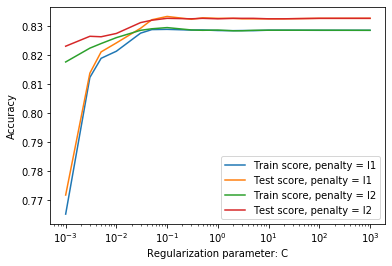

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

c_range = [0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20,100,1000]
train_score_l1 = []
train_score_l2 = []
test_score_l1 = []
test_score_l2 = []

for c in c_range:
    log_l1 = LogisticRegression(penalty = 'l1', C = c)
    log_l2 = LogisticRegression(penalty = 'l2', C = c)
    log_l1.fit(X_train, y_train)
    log_l2.fit(X_train, y_train)
    train_score_l1.append(log_l1.score(X_train, y_train))
    train_score_l2.append(log_l2.score(X_train, y_train))
    test_score_l1.append(log_l1.score(X_test, y_test))
    test_score_l2.append(log_l2.score(X_test, y_test))
    
    
plt.plot(c_range, train_score_l1, label = 'Train score, penalty = l1')
plt.plot(c_range, test_score_l1, label = 'Test score, penalty = l1')
plt.plot(c_range, train_score_l2, label = 'Train score, penalty = l2')
plt.plot(c_range, test_score_l2, label = 'Test score, penalty = l2')
plt.legend()
plt.xlabel('Regularization parameter: C')
plt.ylabel('Accuracy')
plt.xscale('log')

In [90]:
logreg = LogisticRegression(class_weight='balanced')
param1 = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20,100,1000]}
clf1 = GridSearchCV(logreg,param1,scoring='roc_auc',refit=True,cv=5)
clf1.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf1.best_score_, clf1.best_params_))

Best roc_auc: 0.8801, with best C: {'C': 20}


In [91]:
y_pred = clf1.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7877158683610297
[[3578 1073]
 [ 230 1257]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      4651
           1       0.54      0.85      0.66      1487

    accuracy                           0.79      6138
   macro avg       0.74      0.81      0.75      6138
weighted avg       0.84      0.79      0.80      6138



### K Nearest Neighbors Classifier

In [92]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy: 0.8209514499837081
AUC: 0.8343504379748112
Confusion Matrix: [[4175  476]
 [ 623  864]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4651
           1       0.64      0.58      0.61      1487

    accuracy                           0.82      6138
   macro avg       0.76      0.74      0.75      6138
weighted avg       0.82      0.82      0.82      6138



Text(0, 0.5, 'Accuracy')

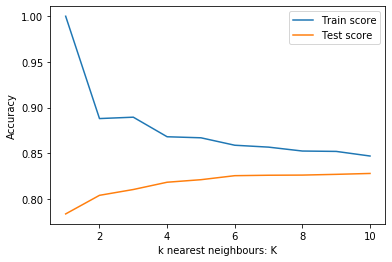

In [93]:
k_range = list(range(1, 11))
train_score_knn = []
test_score_knn = []

for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    train_score_knn.append(neigh.score(X_train, y_train))
    test_score_knn.append(neigh.score(X_test, y_test))
    
plt.plot(k_range, train_score_knn, label = 'Train score')
plt.plot(k_range, test_score_knn, label = 'Test score')
plt.legend()
plt.xlabel('k nearest neighbours: K')
plt.ylabel('Accuracy')

In [94]:
k_range = list(range(1, 11))
knn = KNeighborsClassifier()
param2 = dict(n_neighbors=k_range)
clf2 = GridSearchCV(knn, param2,'roc_auc',refit=True,cv=3)
clf2.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf2.best_score_, clf2.best_params_))

Best roc_auc: 0.8581, with best C: {'n_neighbors': 10}


In [95]:
y_pred = clf2.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8277940697295536
[[4293  358]
 [ 699  788]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4651
           1       0.69      0.53      0.60      1487

    accuracy                           0.83      6138
   macro avg       0.77      0.73      0.74      6138
weighted avg       0.82      0.83      0.82      6138



### Linear SVM 

In [96]:
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
predictions = lsvc.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy: 0.8333333333333334
Confusion Matrix: [[4317  334]
 [ 689  798]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4651
           1       0.70      0.54      0.61      1487

    accuracy                           0.83      6138
   macro avg       0.78      0.73      0.75      6138
weighted avg       0.82      0.83      0.83      6138



In [97]:
param4 = {"C": [0.01, 0.1, 1.0]}
lsvc = LinearSVC()
clf4 = GridSearchCV(lsvc, param4,'roc_auc',refit=True,cv=3)
clf4.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf4.best_score_, clf4.best_params_))

Best roc_auc: 0.8797, with best C: {'C': 1.0}


In [98]:
y_pred = clf4.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8333333333333334
[[4317  334]
 [ 689  798]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4651
           1       0.70      0.54      0.61      1487

    accuracy                           0.83      6138
   macro avg       0.78      0.73      0.75      6138
weighted avg       0.82      0.83      0.83      6138



### SVM with Linear Kernel

In [99]:
SVC_linear = SVC(kernel='linear', probability=True)
SVC_linear.fit(X_train, y_train)
predictions = SVC_linear.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, SVC_linear.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy: 0.830237862495927
AUC: 0.8767675765760075
Confusion Matrix: [[4318  333]
 [ 709  778]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4651
           1       0.70      0.52      0.60      1487

    accuracy                           0.83      6138
   macro avg       0.78      0.73      0.75      6138
weighted avg       0.82      0.83      0.82      6138



In [100]:
param3 = {'C':[0.1, 1, 10],'gamma':[0.1, 1, 10], 'kernel':['linear']}
svc = SVC()
clf3 = GridSearchCV(svc, param3,'roc_auc',refit=True,cv=3)
clf3.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf3.best_score_, clf3.best_params_))

Best roc_auc: 0.8745, with best C: {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


In [101]:
y_pred = clf3.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8300749429781688
[[4317  334]
 [ 709  778]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4651
           1       0.70      0.52      0.60      1487

    accuracy                           0.83      6138
   macro avg       0.78      0.73      0.75      6138
weighted avg       0.82      0.83      0.82      6138



### SVM with RBF Kernel

In [102]:
SVC_rbf = SVC(kernel='rbf', probability=True)
SVC_rbf.fit(X_train, y_train)
predictions = SVC_rbf.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, SVC_rbf.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy: 0.8263277940697296
AUC: 0.877697733543068
Confusion Matrix: [[4364  287]
 [ 779  708]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4651
           1       0.71      0.48      0.57      1487

    accuracy                           0.83      6138
   macro avg       0.78      0.71      0.73      6138
weighted avg       0.82      0.83      0.81      6138



In [103]:
param_rbf = {'C':[0.1, 1, 10],'gamma':[0.1, 1, 10], 'kernel':['rbf']}
svc = SVC()
clf_rbf = GridSearchCV(svc, param_rbf,'roc_auc',refit=True,cv=3)
clf_rbf.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rbf.best_score_, clf_rbf.best_params_))

Best roc_auc: 0.8736, with best C: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


In [104]:
y_pred = clf_rbf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8260019550342131
[[4366  285]
 [ 783  704]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4651
           1       0.71      0.47      0.57      1487

    accuracy                           0.83      6138
   macro avg       0.78      0.71      0.73      6138
weighted avg       0.81      0.83      0.81      6138



### SVM with Poly Kernel

In [105]:
SVC_poly = SVC(kernel='poly', probability=True)
SVC_poly.fit(X_train, y_train)
predictions = SVC_poly.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, SVC_poly.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy: 0.7577386770935158
AUC: 0.8610060935185858
Confusion Matrix: [[4651    0]
 [1487    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      4651
           1       0.00      0.00      0.00      1487

    accuracy                           0.76      6138
   macro avg       0.38      0.50      0.43      6138
weighted avg       0.57      0.76      0.65      6138



In [106]:
param_poly = {'C':[1],'gamma':[0.1, 1], 'kernel':['poly']}
svc = SVC()
clf_poly = GridSearchCV(svc, param_poly,'roc_auc',refit=True,cv=3)
clf_poly.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf_poly.best_score_, clf_poly.best_params_))

Best roc_auc: 0.8613, with best C: {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}


In [107]:
y_pred = clf_poly.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8258390355164549
[[4433  218]
 [ 851  636]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4651
           1       0.74      0.43      0.54      1487

    accuracy                           0.83      6138
   macro avg       0.79      0.69      0.72      6138
weighted avg       0.82      0.83      0.81      6138



### Decision Tree Classifier

In [108]:
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)
predictions = cart.predict(X_test)
print("Accuracy: "+ str(accuracy_score(y_test, predictions)))
print("AUC: "+ str(roc_auc_score(y_test, cart.predict_proba(X_test)[:,1])))
print("Confusion Matrix: "+ str(confusion_matrix(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy: 0.7748452264581297
AUC: 0.7002302040894229
Confusion Matrix: [[3930  721]
 [ 661  826]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4651
           1       0.53      0.56      0.54      1487

    accuracy                           0.77      6138
   macro avg       0.69      0.70      0.70      6138
weighted avg       0.78      0.77      0.78      6138



In [109]:
param5 = {'max_depth': [1,3, 5, 7, 10]}
clf5 = GridSearchCV(DecisionTreeClassifier(), param5,'roc_auc',refit=True,cv=3)
clf5.fit(X_train,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf5.best_score_, clf5.best_params_))

Best roc_auc: 0.8518, with best C: {'max_depth': 5}


In [110]:
import graphviz 
from sklearn import tree
cart1=DecisionTreeClassifier(max_depth=7)
cart1.fit(X=X_train, y=y_train)
dot_data = tree.export_graphviz(cart1, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Decision tree") 

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'Decision tree'], make sure the Graphviz executables are on your systems' PATH

In [111]:
# Testing dataset
y_pred = clf5.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8199739328771587
[[4259  392]
 [ 713  774]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4651
           1       0.66      0.52      0.58      1487

    accuracy                           0.82      6138
   macro avg       0.76      0.72      0.73      6138
weighted avg       0.81      0.82      0.81      6138



# Deep Learning Model

In [112]:
X_train = np.asarray(X_train_without_PCA) 
X_test = np.asarray(X_test_without_PCA) 
y_train = np.asarray(y_train) 
y_test = np.asarray(y_test) 

In [113]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_auc_score
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

classifier = Sequential()

classifier.add(Dense(100, kernel_initializer='normal', activation= 'relu', input_dim=96))
classifier.add(Dense(50, kernel_initializer='normal', activation= 'tanh'))
classifier.add(Dense(25, kernel_initializer='normal', activation= 'softplus'))
classifier.add(Dense(1, kernel_initializer= 'normal', activation= 'sigmoid'))
classifier.compile(optimizer= 'adam',loss='binary_crossentropy', metrics=[auroc])
classifier.fit(X_train, y_train, epochs= 20, batch_size=50)

y_pred = classifier.predict(X_test)
print('Accuracy Score',accuracy_score(y_test, y_pred.round(), normalize = False))
print('Confusion Matrix',confusion_matrix(y_test, y_pred.round()))
print('Classification Report',classification_report(y_test, y_pred.round()))
print('ROC AUC', roc_auc_score(y_test, classifier.predict_proba(X_test)))




Epoch 1/20
24550/24550 [==============================] - 1s 45us/step - loss: 0.3872 - auroc: 0.8762
Epoch 2/20
24550/24550 [==============================] - 1s 40us/step - loss: 0.3432 - auroc: 0.8979: 0s - loss: 0.3473 - 
Epoch 3/20
24550/24550 [==============================] - 1s 39us/step - loss: 0.3323 - auroc: 0.9049
Epoch 4/20
24550/24550 [==============================] - 1s 39us/step - loss: 0.3244 - auroc: 0.9080
Epoch 5/20
24550/24550 [==============================] - 1s 40us/step - loss: 0.3222 - auroc: 0.9113
Epoch 6/20
24550/24550 [==============================] - 1s 39us/step - loss: 0.3167 - auroc: 0.9116
Epoch 7/20
24550/24550 [==============================] - 1s 39us/step - loss: 0.3136 - auroc: 0.9147
Epoch 8/20
24550/24550 [==============================] - 1s 40us/step - loss: 0.3101 - auroc: 0.9164: 0s - loss: 0.3095 - auro
Epoch 9/20
24550/24550 [==============================] - 1s 39us/step - loss: 0.3084 - auroc: 0.9182
Epoch 10/20
24550/24550 [=========